In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator

In [2]:
case_path = os.path.join(os.path.dirname(os.getcwd()), "data", "gantt.csv")

In [39]:
df = pd.read_csv(case_path)
df['Scheduled in Room']=pd.to_datetime(df['Scheduled in Room'])

In [56]:
df['Scheduled in Room'][0].minute

20

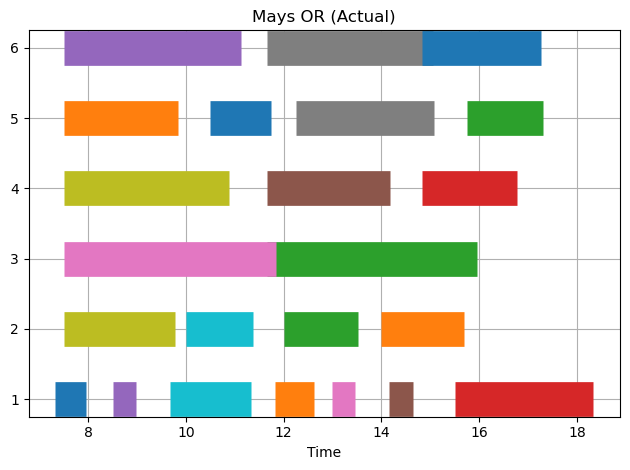

In [68]:
sessions = sorted(list(df['Room'].unique()))

bar_style = {'alpha': 1.0, 'lw': 25, 'solid_capstyle': 'butt'}
text_style = {'color': 'white', 'weight': 'bold', 'ha': 'center', 'va': 'center'}
colors = cm.Dark2.colors

fig, ax = plt.subplots(1, 1)

for s_ix, s in df.iterrows():
    xs = s['Scheduled in Room'].hour + s['Scheduled in Room'].minute /60
#     xf = s['Scheduled in Room'].hour + (s['Scheduled Room Duration'] + s['Scheduled in Room'].minute)/60
    xf = s['Scheduled in Room'].hour + (s['Actual Room Duration'] + s['Scheduled in Room'].minute)/60
    ax.plot([xs, xf], [int(s['Room'][-2:])] * 2, **bar_style)

# ax.set_title('Mays OR (Scheduled)')
ax.set_title('Mays OR (Actual)')
ax.set_xlabel('Time')

ax.set_ylabel('')
ax.grid(True)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))

fig.tight_layout()
plt.show()


In [16]:
pd.to_datetime(df['Scheduled in Room'])

0    2023-04-06 07:20:00
1    2023-04-06 07:30:00
2    2023-04-06 15:45:00
3    2023-04-06 15:30:00
4    2023-04-06 08:30:00
5    2023-04-06 14:10:00
6    2023-04-06 13:00:00
7    2023-04-06 12:15:00
8    2023-04-06 07:30:00
9    2023-04-06 09:40:00
10   2023-04-06 10:30:00
11   2023-04-06 11:50:00
12   2023-04-06 11:40:00
13   2023-04-06 14:50:00
14   2023-04-06 07:30:00
15   2023-04-06 11:40:00
16   2023-04-06 07:30:00
17   2023-04-06 11:40:00
18   2023-04-06 07:30:00
19   2023-04-06 10:00:00
20   2023-04-06 14:50:00
21   2023-04-06 14:00:00
22   2023-04-06 12:00:00
Name: Scheduled in Room, dtype: datetime64[ns]

In [64]:
int(df['Room'][0][-2:])

1

In [34]:
df


,Date,Scheduled in Room,Actual Room Duration,Scheduled Room Duration,Location,Room,min
0,2023/04/06 00:00:00,2023/04/06 07:20:00,38,30,MAYS OR,MAYS_OR 01,2023-04-06 07:20:00
1,2023/04/06 00:00:00,2023/04/06 07:30:00,140,120,MAYS OR,MAYS_OR 05,2023-04-06 07:30:00
2,2023/04/06 00:00:00,2023/04/06 15:45:00,93,60,MAYS OR,MAYS_OR 05,2023-04-06 15:45:00
3,2023/04/06 00:00:00,2023/04/06 15:30:00,170,150,MAYS OR,MAYS_OR 01,2023-04-06 15:30:00
4,2023/04/06 00:00:00,2023/04/06 08:30:00,29,30,MAYS OR,MAYS_OR 01,2023-04-06 08:30:00
5,2023/04/06 00:00:00,2023/04/06 14:10:00,29,30,MAYS OR,MAYS_OR 01,2023-04-06 14:10:00
6,2023/04/06 00:00:00,2023/04/06 13:00:00,28,30,MAYS OR,MAYS_OR 01,2023-04-06 13:00:00
7,2023/04/06 00:00:00,2023/04/06 12:15:00,170,150,MAYS OR,MAYS_OR 05,2023-04-06 12:15:00
8,2023/04/06 00:00:00,2023/04/06 07:30:00,203,190,MAYS OR,MAYS_OR 04,2023-04-06 07:30:00
9,2023/04/06 00:00:00,2023/04/06 09:40:00,100,90,MAYS OR,MAYS_OR 01,2023-04-06 09:40:00
